## Installing the Packages

In [ ]:
!pip install numpy

In [ ]:
!pip install torchxrayvision

In [ ]:
!pip install matplotlib

In [ ]:
!pip install scikit-image

In [ ]:
!pip install torch

In [ ]:
!pip install torchvision

## Preliminaries

In [38]:
# OS and utility libraries
import os
import shutil
from collections import Counter
from tqdm import tqdm

# Image processing and handling
import skimage.io
from skimage import color, io
from skimage.util import img_as_ubyte
from skimage.transform import rotate, rescale, resize, AffineTransform, warp
import imageio
from PIL import Image

# Data manipulation
import pandas as pd
import numpy as np

# Machine learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models, datasets
from torchvision.utils import save_image
import torchxrayvision as xrv
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow (if needed, clarify its purpose)
import tensorflow as tf


## Importing the Data Set

In [2]:
# Directory containing the X-ray images
base_folder = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample'

# Function to load and preprocess images
def load_images_from_folders(base_folder):
    categories = ['Normal', 'Osteopenia', 'Osteoporosis']
    images = []
    labels = []

    for category in categories:
        folder_path = os.path.join(base_folder, category)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            if img_path.lower().endswith((".png", ".jpg", ".jpeg")):
                img = io.imread(img_path)
                img = xrv.datasets.normalize(img, 255)  # Normalize pixel values
                if img.ndim == 3 and img.shape[2] == 3:
                    img = img.mean(axis=2)  # Convert to grayscale if it's RGB
                img = img[None, ...]  # Add a new axis for channel

                # Apply necessary transformations
                transform = transforms.Compose([
                    xrv.datasets.XRayCenterCrop(),
                    xrv.datasets.XRayResizer(512)  # Consider removing if all images are already properly sized
                ])
                img = transform(img)
                img_tensor = torch.from_numpy(img).float()[None, ...]  # Add batch dimension

                images.append(img_tensor)
                labels.append(category)

    return images, labels

# Load images and print distribution
images, labels = load_images_from_folders(base_folder)
label_distribution = Counter(labels)
print(f"Loaded {len(images)} images.")
print("Distribution of categories in the dataset:", label_distribution)

Loaded 98 images.
Distribution of categories in the dataset: Counter({'Osteopenia': 50, 'Osteoporosis': 38, 'Normal': 10})


Seeing that the base file already loaded. We'll proceed to the plotting of the distribution.

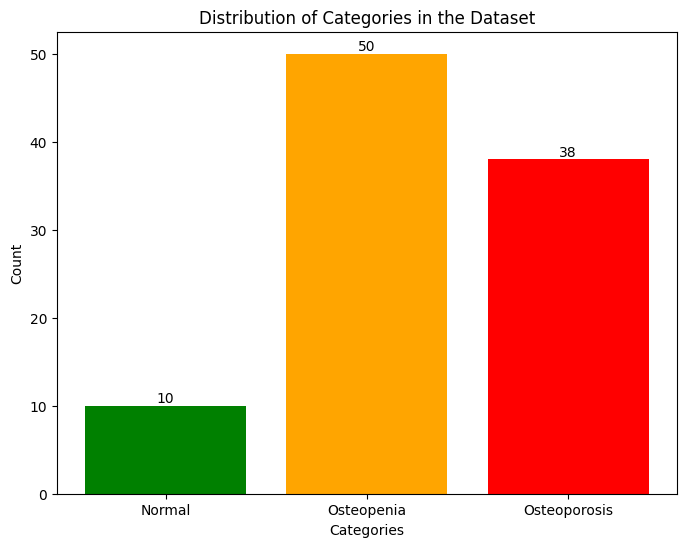

In [3]:
# Setting up the distribution of categories preliminaries
categories = ['Normal', 'Osteopenia', 'Osteoporosis']
counts = [label_distribution[cat] for cat in categories]
colors = ['green', 'orange', 'red']

# Plotting the distribution 
plt.figure(figsize = (8,6))
bars = plt.bar(categories, counts, color = colors)

for bar, count in zip(bars, counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(count, 2), ha = 'center', va = 'bottom', fontsize = 10)

plt.title('Distribution of Categories in the Dataset')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

Upon checking the distribution, we have observed that there is an imbalanced between classes. This could be crucial to the robustness of our model and hence, we'll do some preprocessing to balance the distribution of the classes.

## Image Preprocessing

#### Gamma Correction

For exploratory purposes, let's apply first the preprocessing techniques on a single sample before doing the for-loop to apply it on all of the samples. Let's define the sample image first.

In [4]:
# Define the file path for the specific image
image_path = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Normal\00000012.JPG'

# Load and preprocess the image
img = skimage.io.imread(image_path)
img = img.mean(2)[None, ...]  # Convert to grayscale

# Create a transform pipeline for preprocessing the image
transform = transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(512)
])

img_tensor = transform(img)
img_tensor = torch.from_numpy(img_tensor).unsqueeze(0)  # Add batch dimension

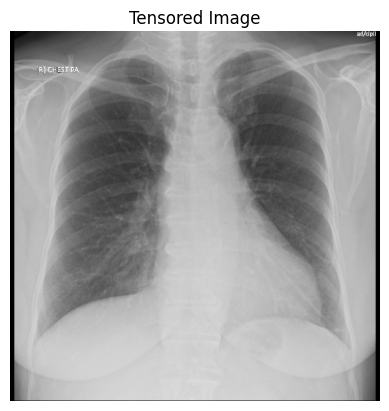

In [5]:
# Display the preprocessed image
plt.imshow(img_tensor[0, 0], cmap='gray')
plt.title('Tensored Image')
plt.axis('off')
plt.show()

##### Specific Case

In [6]:
def adjust_gamma(image, gamma = 1.0):
    img_float = image.astype(float)
    img_normalized = img_float / 255.0
    gamma_corrected = np.power(img_normalized, gamma)
    gamma_corrected = np.clip(gamma_corrected * 255, 0, 255).astype(np.uint8)
    return gamma_corrected

In [7]:
# Applying gamma correction
gamma_value = 2.2
gamma_img = adjust_gamma(img[0], gamma=gamma_value)  # Ensure to pass the correct image format

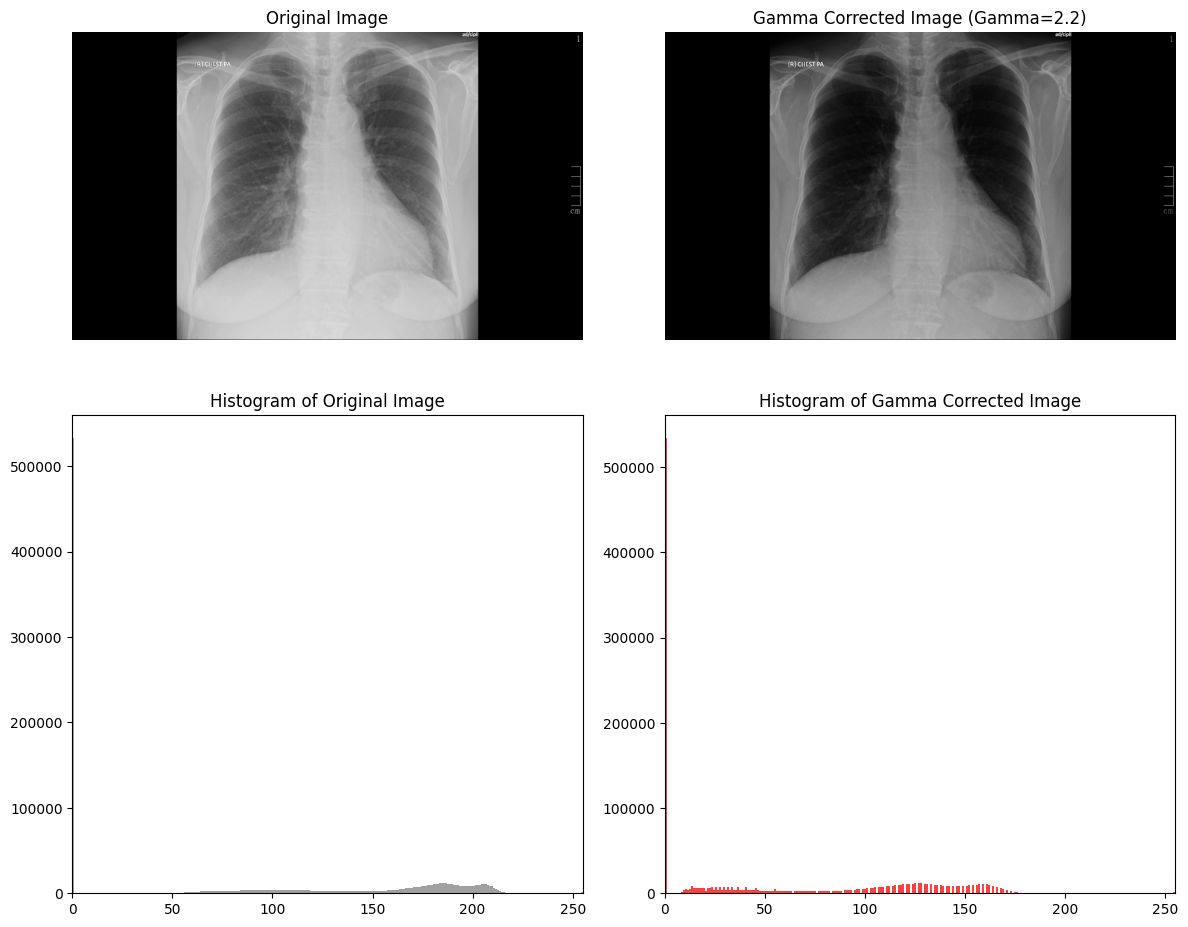

In [8]:
# Displaying the original image, gamma-corrected image, and their respective histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].imshow(img[0], cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')
axs[0, 1].imshow(gamma_img, cmap='gray')
axs[0, 1].set_title(f'Gamma Corrected Image (Gamma={gamma_value})')
axs[0, 1].axis('off')
axs[1, 0].hist(img[0].ravel(), bins=256, color='gray', alpha=0.75)
axs[1, 0].set_title('Histogram of Original Image')
axs[1, 0].set_xlim([0, 255])
axs[1, 1].hist(gamma_img.ravel(), bins=256, color='red', alpha=0.75)
axs[1, 1].set_title('Histogram of Gamma Corrected Image')
axs[1, 1].set_xlim([0, 255])
plt.tight_layout()
plt.show()

##### Saving the Gamma Corrected Image into the device

Using function defintions to streamline adjustments.

In [9]:
def adjust_gamma(image, gamma=1.0):
    """Applies gamma correction to an image."""
    img_float = image.astype(float)
    img_normalized = img_float / 255.0
    gamma_corrected = np.power(img_normalized, gamma)
    gamma_corrected = np.clip(gamma_corrected * 255, 0, 255).astype(np.uint8)
    return gamma_corrected

def load_and_preprocess_image(image_path, transform):
    """Loads an image, converts it to grayscale, and applies transformations."""
    img = skimage.io.imread(image_path)
    if img.ndim == 3 and img.shape[2] == 3:
        img = img.mean(axis=2)  # Convert to grayscale
    img = img[None, ...]  # Add a channel dimension
    img_tensor = transform(img)
    img_tensor = torch.from_numpy(img_tensor).float().unsqueeze(0)  # Add batch dimension
    return img_tensor[0, 0].numpy()  # Return the numpy array of the image

def process_images(base_dir, save_dir, gamma_value=2.2):
    """Processes images from a directory and saves gamma-corrected versions."""
    # Define the transformation pipeline
    transform = transforms.Compose([
        xrv.datasets.XRayCenterCrop(),
        xrv.datasets.XRayResizer(512)
    ])
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    files = [f for f in os.listdir(base_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    # Initialize the progress bar
    for filename in tqdm(files, desc="Processing images", unit="image"):
        image_path = os.path.join(base_dir, filename)
        img = load_and_preprocess_image(image_path, transform)
        gamma_img = adjust_gamma(img, gamma=gamma_value)
        save_path = os.path.join(save_dir, f"gamma_{filename}")
        skimage.io.imsave(save_path, img_as_ubyte(gamma_img))

for Normal Images

In [10]:
# Specify the base directory containing the images and the directory to save gamma-corrected images
base_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Normal'
save_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Gamma Corrected Images - Normal'

# Call the function to process and save gamma-corrected images
process_images(base_dir, save_dir)

Processing images: 100%|████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.17image/s]


for Osteopenia

In [11]:
# Specify the base directory containing the images and the directory to save gamma-corrected images
base_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Osteopenia'
save_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Gamma Corrected Images - Osteopenia'

# Call the function to process and save gamma-corrected images
process_images(base_dir, save_dir)

Processing images: 100%|████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.15image/s]


for Osteoporosis

In [12]:
# Specify the base directory containing the images and the directory to save gamma-corrected images
base_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Osteoporosis'
save_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Gamma Corrected Images - Osteoporosis'

# Call the function to process and save gamma-corrected images
process_images(base_dir, save_dir)

Processing images: 100%|████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 16.53image/s]


#### Extracting the Local Region of Interest

Let's first create a sample of the isolation of the local ROI via the TorchXRayVision Algorithm.

##### Specific Case

For exploratory purposes, let's apply first the preprocessing techniques on a single sample before doing the for-loop to apply it on all of the samples. Let's define the sample image first.

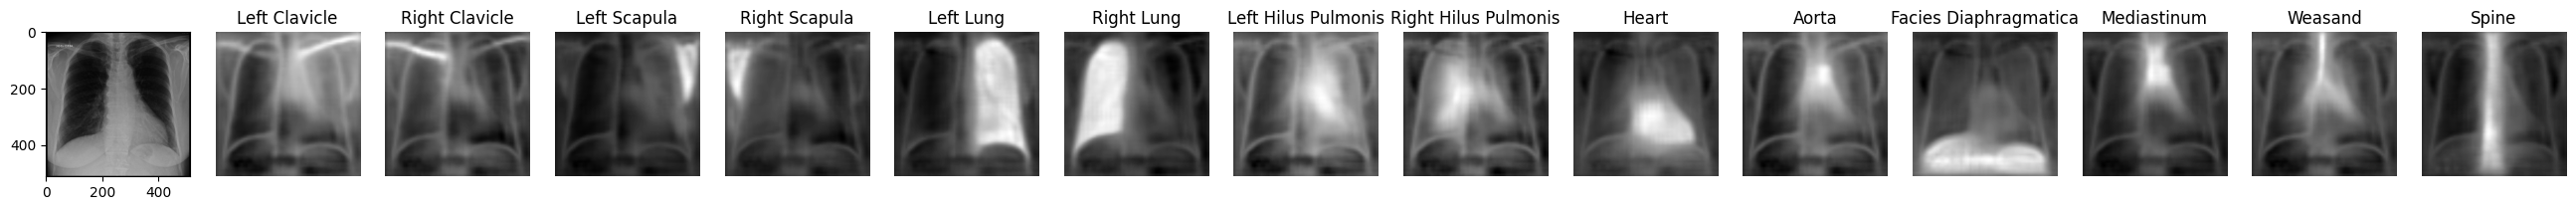

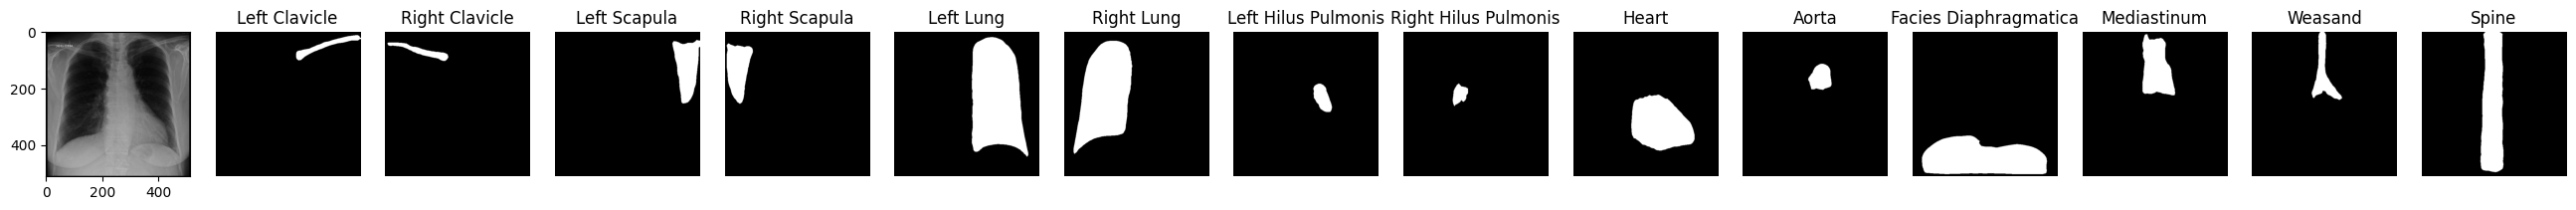

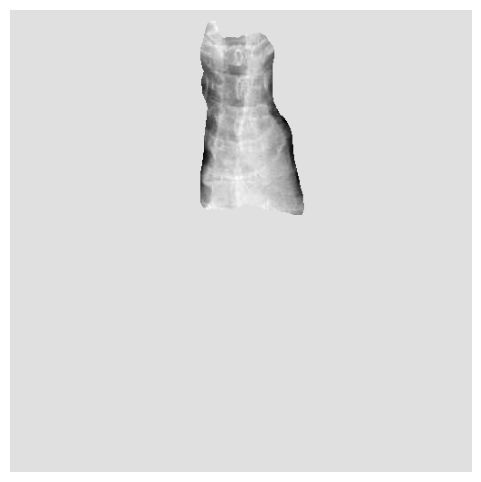

In [13]:
# Load the pretrained model from TorchXrayVIsion
model = xrv.baseline_models.chestx_det.PSPNet()
model.eval()  # Set the model to evaluation mode

# Define the file path for the specific image
image_path = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Gamma Corrected Images - Normal\gamma_00000012.JPG'

# Load the image directly into a tensor
img = skimage.io.imread(image_path)
img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # Add channel and batch dimensions

# Apply the model to the image
with torch.no_grad():
    pred = model(img_tensor)

# Visualize the original image and the predictions
plt.figure(figsize=(26, 5))
plt.subplot(1, len(model.targets) + 1, 1)
plt.imshow(img_tensor[0, 0], cmap='gray')  # Display the original image
for i, target in enumerate(model.targets):
    plt.subplot(1, len(model.targets) + 1, i + 2)
    plt.imshow(pred[0, i].numpy(), cmap='gray')  # Display the model predictions
    plt.title(target)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Apply sigmoid to prediction to convert logits to probabilities
pred = 1 / (1 + np.exp(-pred))  # Sigmoid Function
pred = (pred > 0.5).float()  # Binarize predictions

# Re-visualize the thresholded predictions
plt.figure(figsize=(26, 5))
plt.subplot(1, len(model.targets) + 1, 1)
plt.imshow(img_tensor[0, 0], cmap='gray')  # Display the original image
for i, target in enumerate(model.targets):
    plt.subplot(1, len(model.targets) + 1, i + 2)
    plt.imshow(pred[0, i].numpy(), cmap='gray')  # Display the binary segmentation
    plt.title(target)
    plt.axis('off')
plt.tight_layout()
plt.show()

# As 'mediastinum' is our Local ROI and is available in the TorchXrayVision
mediastinum_index = model.targets.index('Mediastinum') if 'Mediastinum' in model.targets else None

if mediastinum_index is not None:
   # Apply sigmoid to get probabilities
    mediastinum_pred = torch.sigmoid(pred[0, mediastinum_index])
    # Create a binary mask for where the Mediastinum prediction is greater than 0.5
    mediastinum_mask = (mediastinum_pred > 0.5).float()

    # Use the binary mask to select the Mediastinum region from the original X-ray image
    isolated_mediastinum = img_tensor[0, 0] * mediastinum_mask

    # Visualize the isolated Mediastinum on the original X-ray image
    plt.figure(figsize=(6, 6))
    plt.imshow(isolated_mediastinum.numpy(), cmap='gray')
    plt.axis('off')
    plt.show()
else:
    print("Mediastinum target not found in the model's outputs.")


##### Saving the Local ROI into the device

Using function defintions to streamline adjustments.

In [14]:
# Use magic commands for auto-reloading external modules
%load_ext autoreload
%autoreload 2


def process_and_save_rois(base_dir, save_dir, model):
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Gather all image files
    image_files = [f for f in os.listdir(base_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Process images with a progress bar
    for filename in tqdm(image_files, desc='Processing images'):
        image_path = os.path.join(base_dir, filename)
        img = skimage.io.imread(image_path)
        img = xrv.datasets.normalize(img, 255)  # Normalize the image for model compatibility
        img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # Add channel and batch dimensions
        
        # Apply the model to the image
        with torch.no_grad():
            pred = model(img_tensor)
        
        # As 'mediastinum' is our Local ROI and is available in the TorchXrayVision
        mediastinum_index = model.targets.index('Mediastinum') if 'Mediastinum' in model.targets else None
        
        if mediastinum_index is not None:
            mediastinum_pred = torch.sigmoid(pred[0, mediastinum_index])
            mediastinum_mask = (mediastinum_pred > 0.5).float()
            
            isolated_mediastinum = img_tensor[0, 0] * mediastinum_mask
            
            # Save the isolated image
            save_path = os.path.join(save_dir, f'Isolated_{filename}')
            plt.figure(figsize=(6, 6))
            plt.imshow(isolated_mediastinum.numpy(), cmap='gray')
            plt.axis('off')
            plt.savefig(save_path)
            plt.close()
        else:
            print(f"Mediastinum target not found in the model's outputs for {filename}.")

# Load the pretrained model from torchxrayvision
model = xrv.baseline_models.chestx_det.PSPNet()
model.eval()  # Set the model to evaluation mode

chestx-det-pspnet

for Normal Images

In [15]:
# Specify directories for the function execution
base_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Gamma Corrected Images - Normal'
save_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Local ROIs - Normal'

# Process images and save Local ROI
process_and_save_rois(base_dir, save_dir, model)

Processing images: 100%|███████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.10s/it]


for Osteopenia Images

In [16]:
# Specify directories for the function execution
base_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Gamma Corrected Images - Osteopenia'
save_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Local ROIs - Osteopenia'

# Process images and save Local ROI
process_and_save_rois(base_dir, save_dir, model)

Processing images: 100%|███████████████████████████████████████████████████████████████| 50/50 [05:04<00:00,  6.09s/it]


for Osteoporosis Images

In [17]:
# Specify directories for the function execution
base_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Gamma Corrected Images - Osteoporosis'
save_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Local ROIs - Osteoporosis'

# Process images and save Local ROI
process_and_save_rois(base_dir, save_dir, model)

Processing images: 100%|███████████████████████████████████████████████████████████████| 38/38 [03:58<00:00,  6.28s/it]


#### Data Splitting

Given that we are dealing with unbalanced classes, stratified sampling approach will be done to maintain the proportion of each classes during the data splitting part. An 80-10-10 Train-Validation-Test Approach will be done to split the data. Both the Global and Local ROI will undergo data splitting.

In [18]:
def load_dataset(base_dir, roi_type='Global'):
    categories = ['Normal', 'Osteopenia', 'Osteoporosis']
    data = []
    for category in categories:
        class_dir = os.path.join(base_dir, f'{roi_type} ROIs - {category}')
        files = os.listdir(class_dir)
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                data.append({'path': os.path.join(class_dir, file), 'label': category, 'file': file})
    return pd.DataFrame(data)

def stratified_split(data_df, train_size=0.8, test_size=0.1, random_state=42):
    train_df, temp_df = train_test_split(
        data_df, train_size=train_size, stratify=data_df['label'], random_state=random_state
    )
    test_size_adjusted = test_size / (1 - train_size)
    val_df, test_df = train_test_split(
        temp_df, test_size=test_size_adjusted, stratify=temp_df['label'], random_state=random_state
    )
    return train_df, val_df, test_df

def save_split_data(df, save_dir, split_type):
    for index, row in df.iterrows():
        category_dir = os.path.join(save_dir, split_type, row['label'])
        if not os.path.exists(category_dir):
            os.makedirs(category_dir)
        shutil.copy(row['path'], os.path.join(category_dir, row['file']))

In [19]:
# Specify directories
base_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample'
save_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits'

##### Global ROI

In [21]:
# For Global ROIs
global_dataset_df = load_dataset(base_dir, roi_type='Global')
global_train_df, global_val_df, global_test_df = stratified_split(global_dataset_df)
print(f"Global Training Data: {len(global_train_df)} samples")
print(f"Global Validation Data: {len(global_val_df)} samples")
print(f"Global Test Data: {len(global_test_df)} samples")

Global Training Data: 78 samples
Global Validation Data: 9 samples
Global Test Data: 11 samples


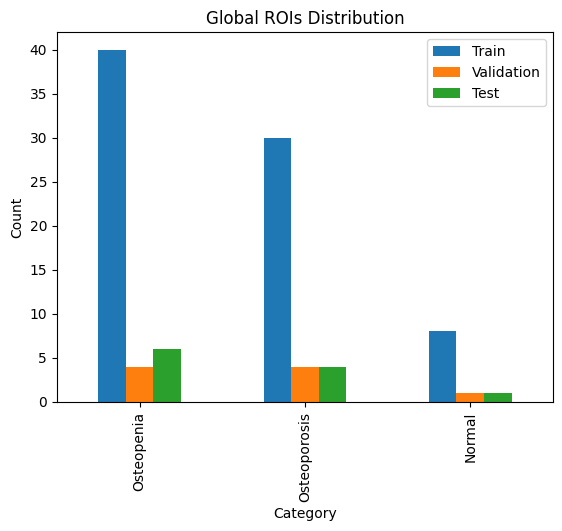

In [22]:
# Plot the distribution of data categories in train, validation, and test sets for Global ROIs
fig, ax = plt.subplots()
data = {
    'Train': global_train_df['label'].value_counts(),
    'Validation': global_val_df['label'].value_counts(),
    'Test': global_test_df['label'].value_counts()
}
df = pd.DataFrame(data)
df.plot(kind='bar', ax=ax)
ax.set_title('Global ROIs Distribution')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.show()

In [23]:
# Save split data
save_split_data(global_train_df, save_dir, 'train_global')
save_split_data(global_val_df, save_dir, 'val_global')
save_split_data(global_test_df, save_dir, 'test_global')

##### Local ROI

In [24]:
# For Local ROIs
local_dataset_df = load_dataset(base_dir, roi_type='Local')
local_train_df, local_val_df, local_test_df = stratified_split(local_dataset_df)
print(f"Local Training Data: {len(local_train_df)} samples")
print(f"Local Validation Data: {len(local_val_df)} samples")
print(f"Local Test Data: {len(local_test_df)} samples")

Local Training Data: 78 samples
Local Validation Data: 9 samples
Local Test Data: 11 samples


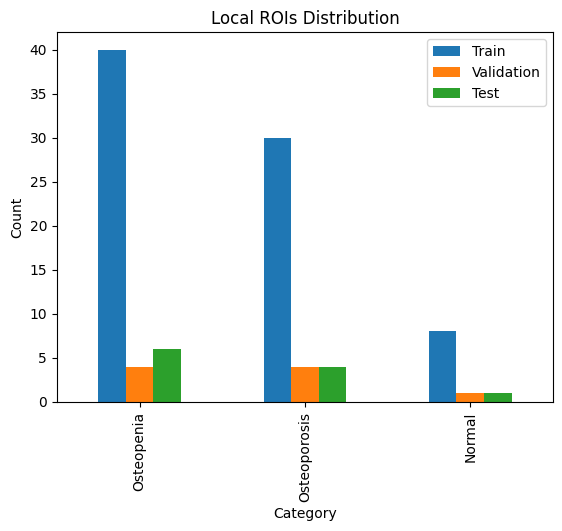

In [25]:
# Plot the distribution of data categories in train, validation, and test sets for Local ROIs
fig, ax = plt.subplots()
data = {
    'Train': local_train_df['label'].value_counts(),
    'Validation': local_val_df['label'].value_counts(),
    'Test': local_test_df['label'].value_counts()
}
df = pd.DataFrame(data)
df.plot(kind='bar', ax=ax)
ax.set_title('Local ROIs Distribution')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.show()

In [26]:
# Save split data
save_split_data(local_train_df, save_dir, 'train_local')
save_split_data(local_val_df, save_dir, 'val_local')
save_split_data(local_test_df, save_dir, 'test_local')

#### Data Augmentation

For Data Augmentation, we will do Rotation, Scaling, Shearing, Translation and Horizontal Flipping. The target count for the Train-Validation-Test will be 1000-125-125 for each of the classes.

In [27]:
def augment_image(image):
    """Apply transformations to augment the grayscale image."""
    # Rotation
    rotated = rotate(image, np.random.uniform(-20, 20), mode='wrap')
    # Scaling
    scale_factor = np.random.uniform(0.8, 1.2)
    scaled = rescale(rotated, scale=scale_factor, mode='reflect', anti_aliasing=True)
    # Shearing
    af_trans = AffineTransform(shear=np.random.uniform(-0.262, 0.262))
    sheared = warp(scaled, inverse_map=af_trans, mode='wrap')
    # Translation
    translation_transform = AffineTransform(translation=(np.random.uniform(-0.1, 0.1) * image.shape[0], 
                                                         np.random.uniform(-0.1, 0.1) * image.shape[1]))
    translated = warp(sheared, inverse_map=translation_transform, mode='wrap')
    # Horizontal Flipping
    if np.random.random() > 0.5:
        flipped = np.fliplr(translated)
    else:
        flipped = translated

    return flipped

In [28]:
def load_and_augment_images(base_dir, target_count):
    """Load images from a directory, augment them, and save them back to disk."""
    categories = ['Normal', 'Osteopenia', 'Osteoporosis']
    
    for category in categories:
        folder_path = os.path.join(base_dir, category)
        image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        augmented_images = []
        
        # Initialize progress bar for this category
        category_pbar = tqdm(total=target_count, desc=f"Processing {category} images", unit="image", position=categories.index(category))
        
        while len(augmented_images) < target_count:
            for image_path in image_files:
                if len(augmented_images) >= target_count:
                    break
                # Use PIL instead of imageio to open the image
                with Image.open(image_path) as img:
                    image = np.array(img.convert('L'))  # Ensure grayscale
                augmented_image = augment_image(image)
                augmented_images.append(augmented_image)
                # Simplified naming convention
                save_path = os.path.join(folder_path, f'Augmented-{category}-{len(augmented_images)}.jpg')
                imageio.imwrite(save_path, img_as_ubyte(augmented_image))  # Save the augmented image
                category_pbar.update(1)  # Update the category's progress bar
                
        category_pbar.close()  # Close progress bar after completion for the category

##### For Train Set

In [29]:
# Local ROI
aug_train_local = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits\train_local'
target_count = 1000  # Desired number of images per category
load_and_augment_images(aug_train_local, target_count)

Processing Normal images: 100%|█████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.06image/s]

Processing Osteopenia images: 100%|█████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.21image/s]


Processing Osteoporosis images:   0%|                                                      | 0/1000 [00:00<?, ?image/s]

Processing Osteoporosis images:   0%|                                              | 2/1000 [00:00<01:03, 15.75image/s]

Processing Osteoporosis images:   0%|▏                                             | 4/1000 [00:00<01:12, 13.72image/s]

Processing Osteoporosis images:   1%|▎                                             | 7/1000 [00:00<01:00, 16.51image/s]

Processing Osteoporosis images:   1%|▍                                            | 10/1000 [00:00<00:52, 19.00image/s]

Processing Osteoporosis images:   1%|▌                                            | 13/1000 [00:00<00:49, 20.09image/s]

Processing Osteoporosis images:

In [30]:
# Global ROI
aug_train_global = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits\train_global'
target_count = 1000  # Desired number of images per category
load_and_augment_images(aug_train_global, target_count)

Processing Normal images: 100%|█████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.17image/s]

Processing Osteopenia images: 100%|█████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.49image/s]


Processing Osteoporosis images:   0%|                                                      | 0/1000 [00:00<?, ?image/s]

Processing Osteoporosis images:   0%|                                              | 2/1000 [00:00<00:52, 19.05image/s]

Processing Osteoporosis images:   0%|▏                                             | 5/1000 [00:00<00:46, 21.53image/s]

Processing Osteoporosis images:   1%|▎                                             | 8/1000 [00:00<00:45, 22.04image/s]

Processing Osteoporosis images:   1%|▍                                            | 11/1000 [00:00<00:41, 23.80image/s]

Processing Osteoporosis images:   1%|▋                                            | 14/1000 [00:00<00:39, 24.69image/s]

Processing Osteoporosis images:

##### For Validation Set

In [31]:
# Local ROI
aug_val_local = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits\val_local'
target_count = 250  # Desired number of images per category
load_and_augment_images(aug_val_local, target_count)

Processing Normal images: 100%|███████████████████████████████████████████████████| 250/250 [00:11<00:00, 22.30image/s]

Processing Osteopenia images: 100%|███████████████████████████████████████████████| 250/250 [00:11<00:00, 21.49image/s]


Processing Osteoporosis images:   0%|                                                       | 0/250 [00:00<?, ?image/s]

Processing Osteoporosis images:   1%|▍                                              | 2/250 [00:00<00:13, 17.89image/s]

Processing Osteoporosis images:   2%|▉                                              | 5/250 [00:00<00:12, 20.26image/s]

Processing Osteoporosis images:   3%|█▌                                             | 8/250 [00:00<00:10, 22.70image/s]

Processing Osteoporosis images:   4%|██                                            | 11/250 [00:00<00:11, 21.63image/s]

Processing Osteoporosis images:   6%|██▌                                           | 14/250 [00:00<00:11, 21.12image/s]

Processing Osteoporosis images:

In [32]:
# Global ROI
aug_val_global = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits\val_global'
target_count = 250  # Desired number of images per category
load_and_augment_images(aug_val_global, target_count)

Processing Normal images: 100%|███████████████████████████████████████████████████| 250/250 [00:08<00:00, 29.04image/s]

Processing Osteopenia images: 100%|███████████████████████████████████████████████| 250/250 [00:08<00:00, 28.26image/s]


Processing Osteoporosis images:   0%|                                                       | 0/250 [00:00<?, ?image/s]

Processing Osteoporosis images:   1%|▌                                              | 3/250 [00:00<00:10, 23.15image/s]

Processing Osteoporosis images:   2%|█▏                                             | 6/250 [00:00<00:09, 25.34image/s]

Processing Osteoporosis images:   4%|█▋                                             | 9/250 [00:00<00:09, 26.31image/s]

Processing Osteoporosis images:   5%|██▏                                           | 12/250 [00:00<00:09, 26.39image/s]

Processing Osteoporosis images:   6%|██▊                                           | 15/250 [00:00<00:08, 26.54image/s]

Processing Osteoporosis images:

##### For Test Set

In [33]:
# Local ROI
aug_test_local = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits\test_local'
target_count = 250  # Desired number of images per category
load_and_augment_images(aug_test_local, target_count)

Processing Normal images: 100%|███████████████████████████████████████████████████| 250/250 [00:11<00:00, 22.03image/s]

Processing Osteopenia images: 100%|███████████████████████████████████████████████| 250/250 [00:11<00:00, 21.39image/s]


Processing Osteoporosis images:   0%|                                                       | 0/250 [00:00<?, ?image/s]

Processing Osteoporosis images:   1%|▍                                              | 2/250 [00:00<00:13, 18.54image/s]

Processing Osteoporosis images:   2%|▊                                              | 4/250 [00:00<00:12, 19.12image/s]

Processing Osteoporosis images:   3%|█▎                                             | 7/250 [00:00<00:11, 20.76image/s]

Processing Osteoporosis images:   4%|█▊                                            | 10/250 [00:00<00:11, 21.62image/s]

Processing Osteoporosis images:   5%|██▍                                           | 13/250 [00:00<00:10, 22.85image/s]

Processing Osteoporosis images:

In [34]:
# Global ROI
aug_test_global = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits\test_global'
target_count = 250  # Desired number of images per category
load_and_augment_images(aug_test_global, target_count)

Processing Normal images: 100%|███████████████████████████████████████████████████| 250/250 [00:08<00:00, 29.43image/s]

Processing Osteopenia images: 100%|███████████████████████████████████████████████| 250/250 [00:08<00:00, 28.05image/s]


Processing Osteoporosis images:   0%|                                                       | 0/250 [00:00<?, ?image/s]

Processing Osteoporosis images:   1%|▌                                              | 3/250 [00:00<00:10, 24.63image/s]

Processing Osteoporosis images:   2%|█▏                                             | 6/250 [00:00<00:08, 27.51image/s]

Processing Osteoporosis images:   4%|█▋                                             | 9/250 [00:00<00:08, 27.28image/s]

Processing Osteoporosis images:   5%|██▍                                           | 13/250 [00:00<00:08, 28.84image/s]

Processing Osteoporosis images:   6%|██▉                                           | 16/250 [00:00<00:08, 28.98image/s]

Processing Osteoporosis images:

##### Validating the count

In [38]:
def count_images_in_folders(base_dirs, categories):
    """Count the number of images in each folder for each category across different dataset splits."""
    data = {}
    
    for category in categories:
        category_counts = {}
        
        for dataset_type, base_dir in base_dirs.items():
            dataset_path = os.path.join(base_dir, category)
            num_images = len([f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            category_counts[dataset_type.capitalize()] = num_images
            
        data[category] = category_counts
    
    return pd.DataFrame(data)

def plot_distribution(dataframe, title):
    """Plot the distribution of images for train, validation, and test sets."""
    dataframe.T.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.show()

In [39]:
# Directories for Local and Global ROI datasets
aug_train_local = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits\train_local'
aug_val_local = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits\val_local'
aug_test_local = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits\test_local'

aug_train_global = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits\train_global'
aug_val_global = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits\val_global'
aug_test_global = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits\test_global'

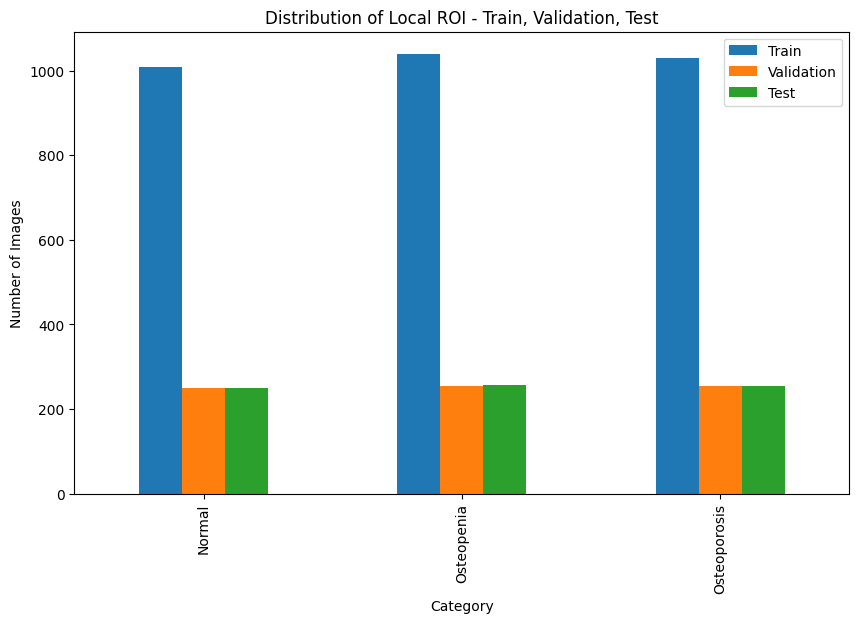

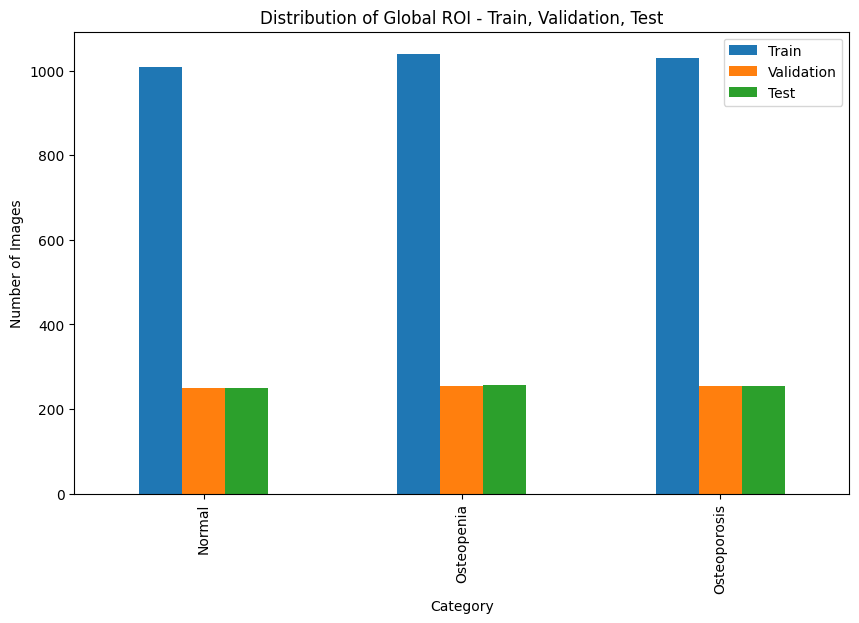

In [40]:
# Define categories
categories = ['Normal', 'Osteopenia', 'Osteoporosis']

# Count images for Local ROI
local_base_dirs = {
    'Train': aug_train_local,
    'Validation': aug_val_local,
    'Test': aug_test_local
}
local_counts_df = count_images_in_folders(local_base_dirs, categories)
plot_distribution(local_counts_df, 'Distribution of Local ROI - Train, Validation, Test')

# Count images for Global ROI
global_base_dirs = {
    'Train': aug_train_global,
    'Validation': aug_val_global,
    'Test': aug_test_global
}
global_counts_df = count_images_in_folders(global_base_dirs, categories)
plot_distribution(global_counts_df, 'Distribution of Global ROI - Train, Validation, Test')

#### Resizing for ResNet50 and EfficientNetb3

For our image data be ready for model training, we will resize them according to the dimensional requirement of ResNet50 and EfficientNetb3. 

In [42]:
# Define the source directory
source_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\Splits'

In [43]:
# Define the folder structure for ResNet50 and EfficientNetB3
resnet50_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\ResNet50 Ready'
efficientnetb3_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\EfficientNetb3 Ready'

In [44]:
# Define target dimensions
resnet50_dim = (224, 224)
efficientnetb3_dim = (300, 300)

In [45]:
# Create directories for ResNet50 and EfficientNetb3 ready images
os.makedirs(resnet50_dir, exist_ok=True)
os.makedirs(efficientnetb3_dir, exist_ok=True)

In [46]:
def resize_images(source_dir, target_dir, target_dim):
    """Resize images to the specified dimensions and save them."""
    categories = ['Normal', 'Osteopenia', 'Osteoporosis']
    splits = ['train_local', 'val_local', 'test_local', 'train_global', 'val_global', 'test_global']
    
    for split in splits:
        for category in categories:
            # Source and target paths
            category_source_dir = os.path.join(source_dir, split, category)
            category_target_dir = os.path.join(target_dir, split, category)
            os.makedirs(category_target_dir, exist_ok=True)

            # Process each image
            image_files = [f for f in os.listdir(category_source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            for image_file in tqdm(image_files, desc=f"Processing {split} - {category}", unit="image"):
                image_path = os.path.join(category_source_dir, image_file)
                image = io.imread(image_path)
                
                # Resize the image using bilinear interpolation
                resized_image = resize(image, target_dim, mode='reflect', anti_aliasing=True)
                
                # Save the resized image to the target directory
                save_path = os.path.join(category_target_dir, image_file)
                io.imsave(save_path, img_as_ubyte(resized_image))

In [47]:
# Resize images for ResNet50 (224x224)
resize_images(source_dir, resnet50_dir, resnet50_dim)

Processing test_global - Osteoporosis: 100%|██████████████████████████████████████| 254/254 [00:03<00:00, 64.06image/s]


In [48]:
# Resize images for EfficientNetB3 (300x300)
resize_images(source_dir, efficientnetb3_dir, efficientnetb3_dim)

Processing test_global - Osteoporosis: 100%|██████████████████████████████████████| 254/254 [00:03<00:00, 82.42image/s]


## Model Training

##### ResNet50

In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
print(torch.__version__)
print(torch.version.cuda)


2.4.1+cu124
12.4


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            print(f"GPU Available: {gpu}")
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available.")

GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
# Transformation (used for all models)
def get_data_transforms(arch):
    if arch == 'resnet50':
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    elif arch == 'efficientnetb3':
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# Function to create data loaders
def create_data_loaders(train_dir, val_dir, arch, batch_size):
    transform = get_data_transforms(arch)
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

In [6]:
# Function to initialize the model
def initialize_model(model_name, num_classes, pretrained=True):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify FC layer
    elif model_name == "efficientnetb3":
        model = models.efficientnet_b3(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Modify classifier
    return model.to(device)

In [7]:
# Function for model training and validation
def train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, arch):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Wrap the train_loader with tqdm for the progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        val_loader_tqdm = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{num_epochs}", unit="batch")

        with torch.no_grad():
            for inputs, labels in val_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'best_model_{arch}.pth')

    print(f'Best Validation Accuracy: {best_acc:.4f}')

In [8]:
# Hyperparameters to experiment with
num_epochs = 10
learning_rate = 0.01
batch_size = 4

In [9]:
# Directories for ResNet50
train_resnet50_global_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\ResNet50 Ready\train_global'
val_resnet50_global_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\ResNet50 Ready\val_global'

train_resnet50_local_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\ResNet50 Ready\train_local'
val_resnet50_local_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\ResNet50 Ready\val_local'

In [10]:
# Train Global ROI ResNet50
train_loader, val_loader = create_data_loaders(train_resnet50_global_dir, val_resnet50_global_dir, 'resnet50', batch_size)
model_resnet50_global = initialize_model("resnet50", num_classes=3)
optimizer = optim.Adam(model_resnet50_global.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_and_validate_model(model_resnet50_global, train_loader, val_loader, criterion, optimizer, num_epochs, 'resnet50_global')

Epoch 1/10
----------


Training Epoch 1/10: 100%|██████████| 770/770 [00:45<00:00, 17.03batch/s]


Training Loss: 1.1546 Acc: 0.3590


Validating Epoch 1/10: 100%|██████████| 190/190 [00:16<00:00, 11.62batch/s]


Validation Loss: 1.1420 Acc: 0.3347
Epoch 2/10
----------


Training Epoch 2/10: 100%|██████████| 770/770 [00:44<00:00, 17.16batch/s]


Training Loss: 1.0966 Acc: 0.3749


Validating Epoch 2/10: 100%|██████████| 190/190 [00:16<00:00, 11.71batch/s]


Validation Loss: 1.1038 Acc: 0.3333
Epoch 3/10
----------


Training Epoch 3/10: 100%|██████████| 770/770 [00:45<00:00, 17.05batch/s]


Training Loss: 1.0855 Acc: 0.3944


Validating Epoch 3/10: 100%|██████████| 190/190 [00:16<00:00, 11.75batch/s]


Validation Loss: 1.1664 Acc: 0.3307
Epoch 4/10
----------


Training Epoch 4/10: 100%|██████████| 770/770 [00:45<00:00, 17.03batch/s]


Training Loss: 1.0848 Acc: 0.3925


Validating Epoch 4/10: 100%|██████████| 190/190 [00:16<00:00, 11.75batch/s]


Validation Loss: 1.1458 Acc: 0.2767
Epoch 5/10
----------


Training Epoch 5/10: 100%|██████████| 770/770 [00:45<00:00, 17.03batch/s]


Training Loss: 1.0876 Acc: 0.3879


Validating Epoch 5/10: 100%|██████████| 190/190 [00:16<00:00, 11.73batch/s]


Validation Loss: 1.2712 Acc: 0.2161
Epoch 6/10
----------


Training Epoch 6/10: 100%|██████████| 770/770 [00:45<00:00, 16.95batch/s]


Training Loss: 1.0882 Acc: 0.3918


Validating Epoch 6/10: 100%|██████████| 190/190 [00:16<00:00, 11.68batch/s]


Validation Loss: 1.1597 Acc: 0.1752
Epoch 7/10
----------


Training Epoch 7/10: 100%|██████████| 770/770 [00:45<00:00, 16.94batch/s]


Training Loss: 1.0784 Acc: 0.3938


Validating Epoch 7/10: 100%|██████████| 190/190 [00:16<00:00, 11.79batch/s]


Validation Loss: 1.2785 Acc: 0.2134
Epoch 8/10
----------


Training Epoch 8/10: 100%|██████████| 770/770 [00:45<00:00, 16.80batch/s]


Training Loss: 1.0856 Acc: 0.3970


Validating Epoch 8/10: 100%|██████████| 190/190 [00:17<00:00, 11.03batch/s]


Validation Loss: 4.0587 Acc: 0.3518
Epoch 9/10
----------


Training Epoch 9/10: 100%|██████████| 770/770 [00:46<00:00, 16.43batch/s]


Training Loss: 1.0921 Acc: 0.3759


Validating Epoch 9/10: 100%|██████████| 190/190 [00:16<00:00, 11.53batch/s]


Validation Loss: 1.2916 Acc: 0.1831
Epoch 10/10
----------


Training Epoch 10/10: 100%|██████████| 770/770 [00:45<00:00, 16.82batch/s]


Training Loss: 1.0755 Acc: 0.3957


Validating Epoch 10/10: 100%|██████████| 190/190 [00:16<00:00, 11.41batch/s]

Validation Loss: 1.2121 Acc: 0.2424
Best Validation Accuracy: 0.3518


In [11]:
# Train Local ROI ResNet50
train_loader, val_loader = create_data_loaders(train_resnet50_local_dir, val_resnet50_local_dir, 'resnet50', batch_size)
model_resnet50_local = initialize_model("resnet50", num_classes=3)
optimizer = optim.Adam(model_resnet50_local.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_and_validate_model(model_resnet50_local, train_loader, val_loader, criterion, optimizer, num_epochs, 'resnet50_local')

Epoch 1/10
----------


Training Epoch 1/10: 100%|██████████| 770/770 [00:45<00:00, 17.07batch/s]


Training Loss: 1.1716 Acc: 0.3476


Validating Epoch 1/10: 100%|██████████| 190/190 [00:16<00:00, 11.49batch/s]


Validation Loss: 1.1036 Acc: 0.3953
Epoch 2/10
----------


Training Epoch 2/10: 100%|██████████| 770/770 [00:45<00:00, 16.87batch/s]


Training Loss: 1.0920 Acc: 0.3674


Validating Epoch 2/10: 100%|██████████| 190/190 [00:16<00:00, 11.48batch/s]


Validation Loss: 1.0646 Acc: 0.3557
Epoch 3/10
----------


Training Epoch 3/10: 100%|██████████| 770/770 [00:45<00:00, 16.80batch/s]


Training Loss: 1.0580 Acc: 0.4168


Validating Epoch 3/10: 100%|██████████| 190/190 [00:16<00:00, 11.45batch/s]


Validation Loss: 1.0973 Acc: 0.3320
Epoch 4/10
----------


Training Epoch 4/10: 100%|██████████| 770/770 [00:45<00:00, 16.89batch/s]


Training Loss: 1.0511 Acc: 0.4129


Validating Epoch 4/10: 100%|██████████| 190/190 [00:16<00:00, 11.41batch/s]


Validation Loss: 1.1497 Acc: 0.3333
Epoch 5/10
----------


Training Epoch 5/10: 100%|██████████| 770/770 [00:45<00:00, 16.79batch/s]


Training Loss: 1.0501 Acc: 0.4168


Validating Epoch 5/10: 100%|██████████| 190/190 [00:16<00:00, 11.46batch/s]


Validation Loss: 1.1345 Acc: 0.2279
Epoch 6/10
----------


Training Epoch 6/10: 100%|██████████| 770/770 [00:45<00:00, 16.92batch/s]


Training Loss: 1.0473 Acc: 0.4038


Validating Epoch 6/10: 100%|██████████| 190/190 [00:16<00:00, 11.57batch/s]


Validation Loss: 1.1740 Acc: 0.1792
Epoch 7/10
----------


Training Epoch 7/10: 100%|██████████| 770/770 [00:45<00:00, 16.76batch/s]


Training Loss: 1.0383 Acc: 0.4282


Validating Epoch 7/10: 100%|██████████| 190/190 [00:16<00:00, 11.52batch/s]


Validation Loss: 1.1419 Acc: 0.2464
Epoch 8/10
----------


Training Epoch 8/10: 100%|██████████| 770/770 [00:45<00:00, 16.90batch/s]


Training Loss: 1.0329 Acc: 0.4396


Validating Epoch 8/10: 100%|██████████| 190/190 [00:16<00:00, 11.34batch/s]


Validation Loss: 1.2154 Acc: 0.1647
Epoch 9/10
----------


Training Epoch 9/10: 100%|██████████| 770/770 [00:45<00:00, 16.84batch/s]


Training Loss: 1.0218 Acc: 0.4587


Validating Epoch 9/10: 100%|██████████| 190/190 [00:16<00:00, 11.49batch/s]


Validation Loss: 1.2435 Acc: 0.2859
Epoch 10/10
----------


Training Epoch 10/10: 100%|██████████| 770/770 [00:45<00:00, 16.91batch/s]


Training Loss: 0.9976 Acc: 0.4743


Validating Epoch 10/10: 100%|██████████| 190/190 [00:16<00:00, 11.55batch/s]

Validation Loss: 1.4438 Acc: 0.2530
Best Validation Accuracy: 0.3953


In [12]:
# Directories for EfficientNetB3
train_efficientnetb3_global_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\EfficientNetB3 Ready\train_global'
val_efficientnetb3_global_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\EfficientNetB3 Ready\val_global'

train_efficientnetb3_local_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\EfficientNetB3 Ready\train_local'
val_efficientnetb3_local_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\EfficientNetB3 Ready\val_local'

In [13]:
# Train Global ROI EfficientNetB3
train_loader, val_loader = create_data_loaders(train_efficientnetb3_global_dir, val_efficientnetb3_global_dir, 'efficientnetb3', batch_size)
model_efficientnetb3_global = initialize_model("efficientnetb3", num_classes=3)
optimizer = optim.Adam(model_efficientnetb3_global.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_and_validate_model(model_efficientnetb3_global, train_loader, val_loader, criterion, optimizer, num_epochs, 'efficientnetb3_global')

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\Vlad/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:21<00:00, 2.27MB/s]


Epoch 1/10
----------


Training Epoch 1/10: 100%|██████████| 770/770 [01:15<00:00, 10.17batch/s]


Training Loss: 1.2364 Acc: 0.3437


Validating Epoch 1/10: 100%|██████████| 190/190 [00:19<00:00,  9.75batch/s]


Validation Loss: 6.7023 Acc: 0.3347
Epoch 2/10
----------


Training Epoch 2/10: 100%|██████████| 770/770 [01:15<00:00, 10.21batch/s]


Training Loss: 1.1763 Acc: 0.3496


Validating Epoch 2/10: 100%|██████████| 190/190 [00:19<00:00,  9.76batch/s]


Validation Loss: 7.2133 Acc: 0.3557
Epoch 3/10
----------


Training Epoch 3/10: 100%|██████████| 770/770 [01:15<00:00, 10.21batch/s]


Training Loss: 1.1483 Acc: 0.3473


Validating Epoch 3/10: 100%|██████████| 190/190 [00:19<00:00,  9.71batch/s]


Validation Loss: 1.2081 Acc: 0.0817
Epoch 4/10
----------


Training Epoch 4/10: 100%|██████████| 770/770 [01:19<00:00,  9.67batch/s]


Training Loss: 1.1484 Acc: 0.3752


Validating Epoch 4/10: 100%|██████████| 190/190 [00:18<00:00, 10.04batch/s]


Validation Loss: 1.2275 Acc: 0.3109
Epoch 5/10
----------


Training Epoch 5/10: 100%|██████████| 770/770 [01:15<00:00, 10.25batch/s]


Training Loss: 1.1351 Acc: 0.3798


Validating Epoch 5/10: 100%|██████████| 190/190 [00:19<00:00,  9.88batch/s]


Validation Loss: 1.2408 Acc: 0.2266
Epoch 6/10
----------


Training Epoch 6/10: 100%|██████████| 770/770 [01:17<00:00,  9.89batch/s]


Training Loss: 1.1166 Acc: 0.3912


Validating Epoch 6/10: 100%|██████████| 190/190 [00:19<00:00,  9.76batch/s]


Validation Loss: 1.2160 Acc: 0.3347
Epoch 7/10
----------


Training Epoch 7/10: 100%|██████████| 770/770 [01:17<00:00,  9.95batch/s]


Training Loss: 1.1416 Acc: 0.3684


Validating Epoch 7/10: 100%|██████████| 190/190 [00:19<00:00,  9.87batch/s]


Validation Loss: 1.3509 Acc: 0.3347
Epoch 8/10
----------


Training Epoch 8/10: 100%|██████████| 770/770 [01:17<00:00,  9.93batch/s]


Training Loss: 1.1407 Acc: 0.3548


Validating Epoch 8/10: 100%|██████████| 190/190 [00:19<00:00, 10.00batch/s]


Validation Loss: 1.1400 Acc: 0.3241
Epoch 9/10
----------


Training Epoch 9/10: 100%|██████████| 770/770 [01:17<00:00,  9.88batch/s]


Training Loss: 1.1049 Acc: 0.4113


Validating Epoch 9/10: 100%|██████████| 190/190 [00:18<00:00, 10.01batch/s]


Validation Loss: 1.4688 Acc: 0.2516
Epoch 10/10
----------


Training Epoch 10/10: 100%|██████████| 770/770 [01:16<00:00, 10.01batch/s]


Training Loss: 1.0649 Acc: 0.4519


Validating Epoch 10/10: 100%|██████████| 190/190 [00:19<00:00,  9.95batch/s]

Validation Loss: 1.1531 Acc: 0.3702
Best Validation Accuracy: 0.3702


In [14]:
# Train Local ROI EfficientNetB3
train_loader, val_loader = create_data_loaders(train_efficientnetb3_local_dir, val_efficientnetb3_local_dir, 'efficientnetb3', batch_size)
model_efficientnetb3_local = initialize_model("efficientnetb3", num_classes=3)
optimizer = optim.Adam(model_efficientnetb3_local.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_and_validate_model(model_efficientnetb3_local, train_loader, val_loader, criterion, optimizer, num_epochs, 'efficientnetb3_local')

Epoch 1/10
----------


Training Epoch 1/10: 100%|██████████| 770/770 [01:14<00:00, 10.30batch/s]


Training Loss: 1.2888 Acc: 0.3343


Validating Epoch 1/10: 100%|██████████| 190/190 [00:20<00:00,  9.42batch/s]


Validation Loss: 1.1686 Acc: 0.3294
Epoch 2/10
----------


Training Epoch 2/10: 100%|██████████| 770/770 [01:19<00:00,  9.70batch/s]


Training Loss: 1.1579 Acc: 0.3577


Validating Epoch 2/10: 100%|██████████| 190/190 [00:19<00:00,  9.77batch/s]


Validation Loss: 1.1724 Acc: 0.3333
Epoch 3/10
----------


Training Epoch 3/10: 100%|██████████| 770/770 [01:17<00:00,  9.93batch/s]


Training Loss: 1.1546 Acc: 0.3405


Validating Epoch 3/10: 100%|██████████| 190/190 [00:19<00:00,  9.87batch/s]


Validation Loss: 1.1294 Acc: 0.3307
Epoch 4/10
----------


Training Epoch 4/10: 100%|██████████| 770/770 [01:17<00:00,  9.88batch/s]


Training Loss: 1.1520 Acc: 0.3275


Validating Epoch 4/10: 100%|██████████| 190/190 [00:19<00:00,  9.78batch/s]


Validation Loss: 1.1883 Acc: 0.3347
Epoch 5/10
----------


Training Epoch 5/10: 100%|██████████| 770/770 [01:19<00:00,  9.64batch/s]


Training Loss: 1.1458 Acc: 0.3606


Validating Epoch 5/10: 100%|██████████| 190/190 [00:19<00:00,  9.83batch/s]


Validation Loss: 1.1198 Acc: 0.2661
Epoch 6/10
----------


Training Epoch 6/10: 100%|██████████| 770/770 [01:17<00:00,  9.90batch/s]


Training Loss: 1.1387 Acc: 0.3441


Validating Epoch 6/10: 100%|██████████| 190/190 [00:18<00:00, 10.01batch/s]


Validation Loss: 1.1242 Acc: 0.3307
Epoch 7/10
----------


Training Epoch 7/10: 100%|██████████| 770/770 [01:19<00:00,  9.74batch/s]


Training Loss: 1.1334 Acc: 0.3655


Validating Epoch 7/10: 100%|██████████| 190/190 [00:20<00:00,  9.46batch/s]


Validation Loss: 0.9930 Acc: 0.3887
Epoch 8/10
----------


Training Epoch 8/10: 100%|██████████| 770/770 [01:16<00:00, 10.01batch/s]


Training Loss: 1.1309 Acc: 0.3600


Validating Epoch 8/10: 100%|██████████| 190/190 [00:19<00:00,  9.69batch/s]


Validation Loss: 1.1492 Acc: 0.3307
Epoch 9/10
----------


Training Epoch 9/10: 100%|██████████| 770/770 [01:18<00:00,  9.81batch/s]


Training Loss: 1.1149 Acc: 0.3749


Validating Epoch 9/10: 100%|██████████| 190/190 [00:19<00:00,  9.82batch/s]


Validation Loss: 1.1118 Acc: 0.3347
Epoch 10/10
----------


Training Epoch 10/10: 100%|██████████| 770/770 [01:17<00:00,  9.95batch/s]


Training Loss: 1.0995 Acc: 0.3970


Validating Epoch 10/10: 100%|██████████| 190/190 [00:19<00:00,  9.77batch/s]

Validation Loss: 1.5104 Acc: 0.2609
Best Validation Accuracy: 0.3887


## Model Evaluation

In [30]:
# Function to load model in evaluation mode
def load_model(model_name, model_type, num_classes=3, model_dir=r'C:\Users\Vlad\Documents\James Thesis\Codes'):
    model = initialize_model(model_name, num_classes)  # Use the same initialize_model function
    model_path = os.path.join(model_dir, f'best_model_{model_type}.pth')
    model.load_state_dict(torch.load(model_path))  # Load the best model weights
    model.eval()  # Set the model to evaluation mode
    return model

In [31]:
# Function to create data loaders
def create_data_loaders(eval_dir, arch, batch_size):
    # Data transformation for evaluation
    data_transform = transforms.Compose([
        transforms.Resize((224 if arch == 'resnet50' else 300, 224 if arch == 'resnet50' else 300)),
        transforms.ToTensor()
    ])
    
    eval_dataset = datasets.ImageFolder(eval_dir, transform=data_transform)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    
    return eval_loader

In [32]:
# Function to evaluate the model
def evaluate_model(model, data_loader, num_classes=3):
    y_true, y_pred, y_probs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    
    return np.array(y_true), np.array(y_pred), np.array(y_probs)

In [33]:
# Function to calculate all evaluation metrics
def calculate_metrics(y_true, y_pred, y_probs, num_classes=3):
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc_score = roc_auc_score(y_true, y_probs, average='macro', multi_class='ovr')
    
    # Specificity & NPV calculations
    specificity_list, npv_list = [], []
    for i in range(num_classes):
        tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
        fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
        fn = conf_matrix[i, :].sum() - conf_matrix[i, i]
        specificity = tn / (tn + fp)
        npv = tn / (tn + fn)
        specificity_list.append(specificity)
        npv_list.append(npv)
    
    specificity = np.mean(specificity_list)
    npv = np.mean(npv_list)
    
    return {
        'confusion_matrix': conf_matrix,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1,
        'auc_score': auc_score,
        'npv': npv
    }

In [34]:
# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [35]:
# Define directories
val_resnet50_global_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\ResNet50 Ready\val_global'
val_resnet50_local_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\ResNet50 Ready\val_local'
val_efficientnetb3_global_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\EfficientNetB3 Ready\val_global'
val_efficientnetb3_local_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes\Dataset Sample\EfficientNetB3 Ready\val_local'

In [36]:
# Model directory where the best models are saved
model_dir = r'C:\Users\Vlad\Documents\James Thesis\Codes'

100%|██████████| 190/190 [00:03<00:00, 61.44it/s]


ResNet50 Global Evaluation Metrics: {'confusion_matrix': array([[  0, 251,   0],
       [  0, 254,   0],
       [  0, 254,   0]], dtype=int64), 'accuracy': 0.3346508563899868, 'precision': 0.11155028546332894, 'recall': 0.3333333333333333, 'specificity': 0.6666666666666666, 'f1_score': 0.1671602500822639, 'auc_score': 0.5, 'npv': nan}


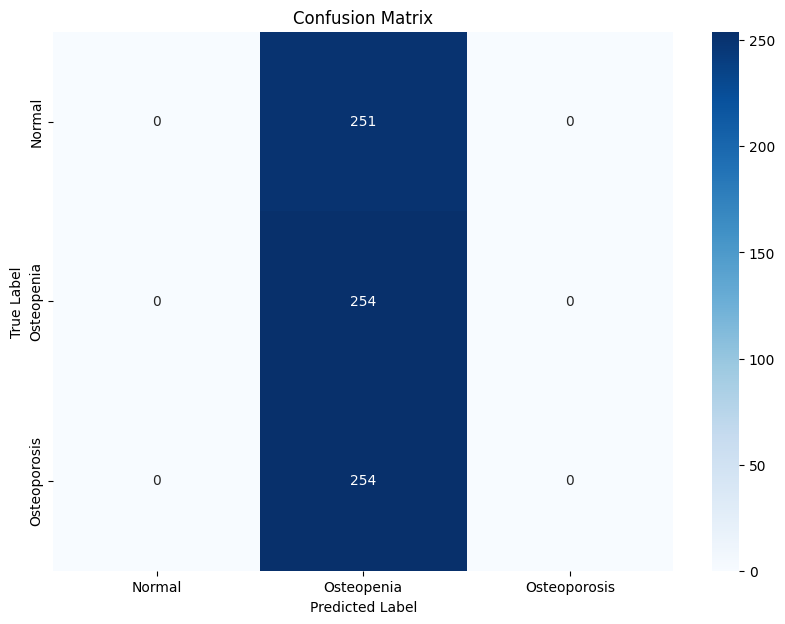

In [39]:
# Evaluation Metrics for ResNet50 Global ROI
val_loader_resnet50_global = create_data_loaders(val_resnet50_global_dir, 'resnet50', batch_size)
model_resnet50_global = load_model('resnet50', 'resnet50_global', num_classes=3, model_dir=model_dir)
y_true_resnet50_global, y_pred_resnet50_global, y_probs_resnet50_global = evaluate_model(model_resnet50_global, val_loader_resnet50_global)
metrics_resnet50_global = calculate_metrics(y_true_resnet50_global, y_pred_resnet50_global, y_probs_resnet50_global)
print("ResNet50 Global Evaluation Metrics:", metrics_resnet50_global)
plot_confusion_matrix(metrics_resnet50_global['confusion_matrix'], ['Normal', 'Osteopenia', 'Osteoporosis'])

100%|██████████| 190/190 [00:03<00:00, 59.38it/s]


ResNet50 Local Evaluation Metrics: {'confusion_matrix': array([[251,   0,   0],
       [254,   0,   0],
       [254,   0,   0]], dtype=int64), 'accuracy': 0.33069828722002637, 'precision': 0.11023276240667546, 'recall': 0.3333333333333333, 'specificity': 0.6666666666666666, 'f1_score': 0.16567656765676567, 'auc_score': 0.6406445914064695, 'npv': nan}


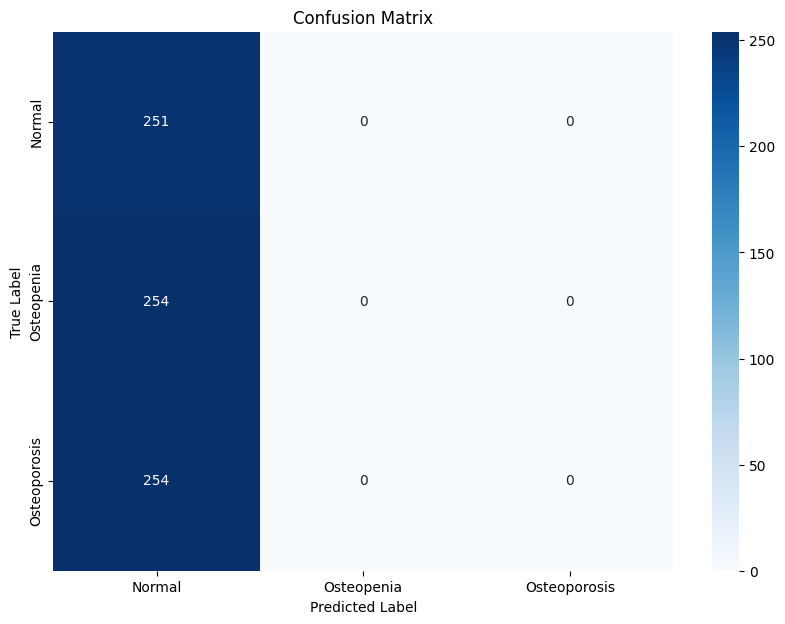

In [40]:
# Evaluation Metrics for ResNet50 Local ROI
val_loader_resnet50_local = create_data_loaders(val_resnet50_local_dir, 'resnet50', batch_size)
model_resnet50_local = load_model('resnet50', 'resnet50_local', num_classes=3, model_dir=model_dir)
y_true_resnet50_local, y_pred_resnet50_local, y_probs_resnet50_local = evaluate_model(model_resnet50_local, val_loader_resnet50_local)
metrics_resnet50_local = calculate_metrics(y_true_resnet50_local, y_pred_resnet50_local, y_probs_resnet50_local)
print("ResNet50 Local Evaluation Metrics:", metrics_resnet50_local)
plot_confusion_matrix(metrics_resnet50_local['confusion_matrix'], ['Normal', 'Osteopenia', 'Osteoporosis'])

100%|██████████| 190/190 [00:06<00:00, 30.77it/s]


EfficientNetB3 Global Evaluation Metrics: {'confusion_matrix': array([[251,   0,   0],
       [254,   0,   0],
       [254,   0,   0]], dtype=int64), 'accuracy': 0.33069828722002637, 'precision': 0.11023276240667546, 'recall': 0.3333333333333333, 'specificity': 0.6666666666666666, 'f1_score': 0.16567656765676567, 'auc_score': 0.42982665114081753, 'npv': nan}


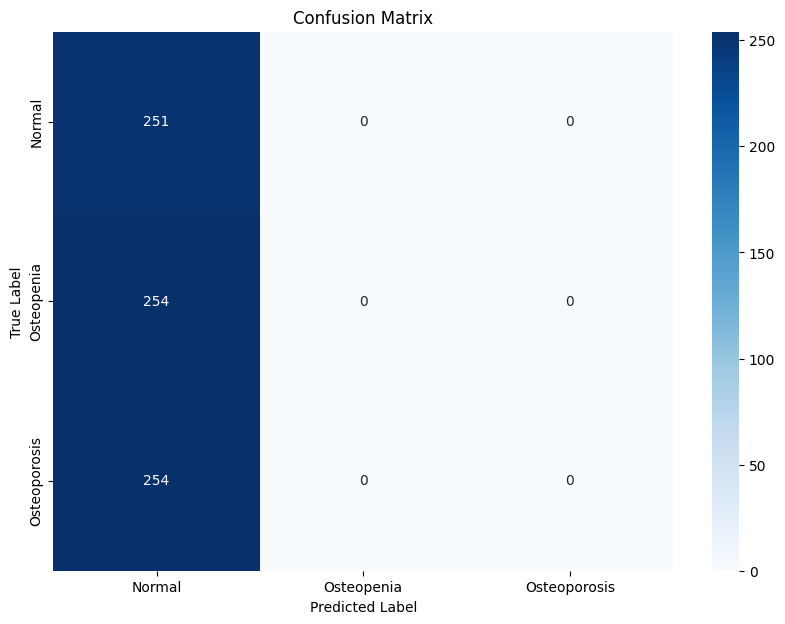

In [41]:
# Evaluation Metrics for EfficientNetB3 Global ROI
val_loader_efficientnetb3_global = create_data_loaders(val_efficientnetb3_global_dir, 'efficientnetb3', batch_size)
model_efficientnetb3_global = load_model('efficientnetb3', 'efficientnetb3_global', num_classes=3, model_dir=model_dir)
y_true_efficientnetb3_global, y_pred_efficientnetb3_global, y_probs_efficientnetb3_global = evaluate_model(model_efficientnetb3_global, val_loader_efficientnetb3_global)
metrics_efficientnetb3_global = calculate_metrics(y_true_efficientnetb3_global, y_pred_efficientnetb3_global, y_probs_efficientnetb3_global)
print("EfficientNetB3 Global Evaluation Metrics:", metrics_efficientnetb3_global)
plot_confusion_matrix(metrics_efficientnetb3_global['confusion_matrix'], ['Normal', 'Osteopenia', 'Osteoporosis'])

100%|██████████| 190/190 [00:05<00:00, 32.49it/s]


EfficientNetB3 Local Evaluation Metrics: {'confusion_matrix': array([[  0, 251,   0],
       [  0, 254,   0],
       [  0, 254,   0]], dtype=int64), 'accuracy': 0.3346508563899868, 'precision': 0.11155028546332894, 'recall': 0.3333333333333333, 'specificity': 0.6666666666666666, 'f1_score': 0.1671602500822639, 'auc_score': 0.5, 'npv': nan}


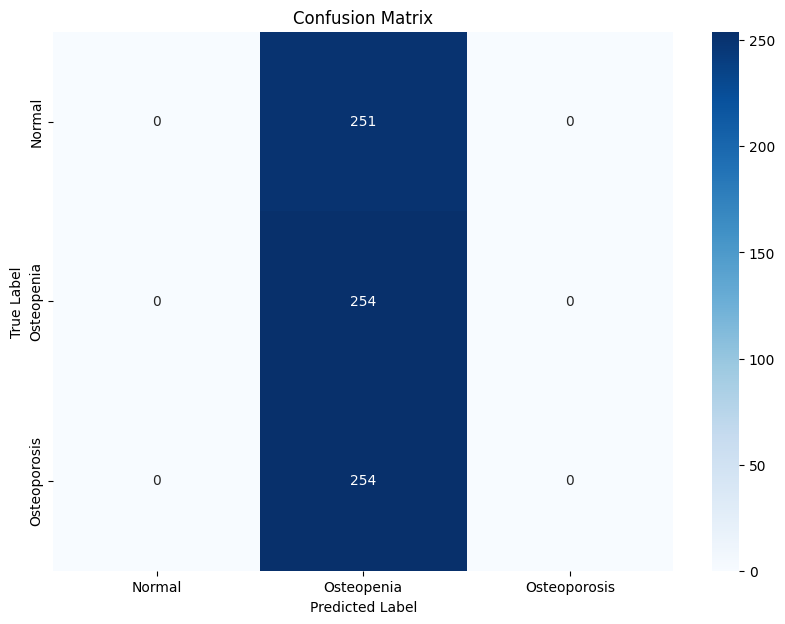

In [42]:
# Evaluation Metrics for EfficientNetB3 Local ROI
val_loader_efficientnetb3_local = create_data_loaders(val_efficientnetb3_local_dir, 'efficientnetb3', batch_size)
model_efficientnetb3_local = load_model('efficientnetb3', 'efficientnetb3_local', num_classes=3, model_dir=model_dir)
y_true_efficientnetb3_local, y_pred_efficientnetb3_local, y_probs_efficientnetb3_local = evaluate_model(model_efficientnetb3_local, val_loader_efficientnetb3_local)
metrics_efficientnetb3_local = calculate_metrics(y_true_efficientnetb3_local, y_pred_efficientnetb3_local, y_probs_efficientnetb3_local)
print("EfficientNetB3 Local Evaluation Metrics:", metrics_efficientnetb3_local)
plot_confusion_matrix(metrics_efficientnetb3_local['confusion_matrix'], ['Normal', 'Osteopenia', 'Osteoporosis'])